In [8]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML
from pymatgen.core.structure import Structure

# Zachary's Karate Club 

In [13]:

graph = nx.karate_club_graph()
graph.number_of_nodes(), graph.number_of_edges()

(34, 78)

In [15]:
communities = greedy_modularity_communities(graph)



In [22]:

colors = np.zeros(graph.number_of_nodes())

for i, community in enumerate(communities):
    colors[list(community)] = i

number_classes = np.unique(colors).shape[0]

labels = np.eye(number_classes)[colors.astype(int)]

In [45]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

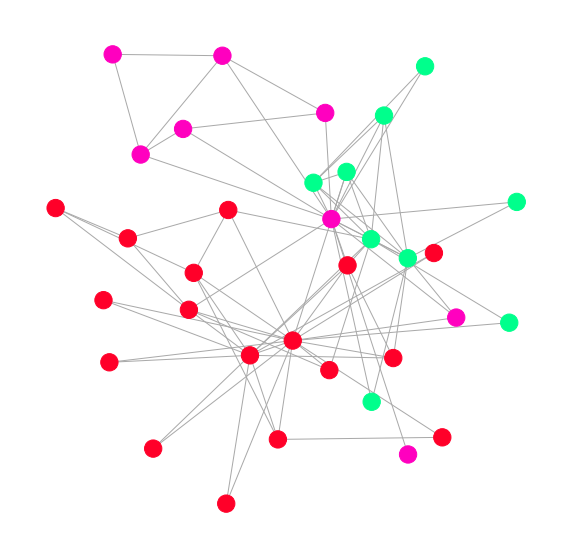

In [48]:
club_labels = nx.get_node_attributes(graph,'club')
_ = draw_kkl(graph, None, colors, cmap='gist_rainbow', edge_color='darkgrey')


In [56]:
A = nx.to_numpy_matrix(graph)
A_mod = A + np.identity(graph.number_of_nodes())
D_mod  = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis = 1)).flatten())
D_mod_inverseroot = np.linalg.inv(sqrtm(D_mod))
A_hat = D_mod_inverseroot @ A_mod @ D_mod_inverseroot
X= np.eye(graph.number_of_nodes())

In [61]:
def glorot_init(nin,nout):
    sd = np.sqrt(6.0/ (nin+nout))
    return np.random.uniform(-sd, sd, size = (nin, nout))

def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))

    


In [70]:
class GradientDescentOptimizer():
    def __init__(self, learning_rate, weight_decay ):
        self.lr = learning_rate
        self.wd = weight_decay
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
    def __call__(self, y_pred, y_true, train_nodes = None):
        self.y_pred = y_pred
        self.y_true = y_true

        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
        self.bs = self.train_nodes.shape[0]

        @property
        def out(self):
            return self._out
        @out.setter
        def out(self, y):
            self._out = y




In [58]:
class GCNLayer(object):
    def __init__(self, n_inputs, n_outputs, activation = None, name = ''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name

    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"

    def forward(self, A, X, W=None):
        '''
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D), 
            where bs = "batch size" and D = input feature length

        '''

        self._A = A
        self._X = (A @ X).T

        if W is None:
            W = self.W

        H = W @ self._X

        if self.activation is not None:
            H = self.activation(H)
        self._H = H
        return self._H.T

    def backward(self, optim, update = True):
        dtanh = 1 - np.asarray(self._H.T)**2
        d2 = np.multiply(optim.out, dtanh) #element wise multiplication

        self.grad = self._A @ d2 @ self.W
        optim.out = self.grad

        dW = np.asarray(d2.T @ self._X.T) / optim.bs

        dW_wd = self.W * optim.wd / optim.bs

        if update:
            self.W -=  (dW + dW_wd) * optim.lr
        return dW + dW_wd

    






    

    

In [65]:
class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name = ''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs,1))
        self.name = name
        self._X = None

    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"

    def shift(self, proj):
        shiftx = proj - np.max(proj, axis = 0, keepdims=True)
        exps = np.exp(shiftx)
        return exps/np.sum(exps, axis = 0, keepdims=True)

    def forward(self, X, W=None, b = None):
        """Compute the softmax of vector x in a numerically stable way.
        
        X is assumed to be (bs, h)
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b
        return self.shift(proj).T

    def backward(self, optim, update = True):
        '''
        should take in optimizer, update its own parameters and update the optimizer's "out"
        Build mask on loss
        '''
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1,1))

        # derivative of loss w.r.t. activation (pre-softmax)

        d1 = np.asarray((optim.y_pred - optim.y_true))
        d1 = np.multiply(d1, train_mask)

        self.grad = d1 @ self.W
        optim.out = self.grad

        dW = (d1.T @ self._X.T)/optim.bs
        db = d1.T.sum(axis =1, keepdims = True)

        dW_wd = self.W * optim.wd / optim.bs

        if update:
            self.W -= (dW + dW_wd ) * optim.lr 
            self.b -= db.reshape(self.b.shape)*optim.lr
        return dW + dW_wd, db.reshape(self.b.shape)  




In [71]:
gcn1 = GCNLayer(graph.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, number_classes, "SM")
opt = GradientDescentOptimizer(learning_rate=0, weight_decay=1.)

In [72]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

# Gradient Checking on Softmax Layer

In [73]:
def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        #print(f"Parm {argname}_{i}")
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jm = xent(predm, labels).mean() + wd_term
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

In [74]:
dW_approx = get_grads((gcn1_out,), sm1, "W", labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((gcn1_out,), sm1, "b", labels, eps=1e-4, wd=opt.wd)

In [75]:
dW, db = sm1.backward(opt, update=False)

# Gradient checking on GCN layer

In [78]:
def get_gcn_grads(inputs, gcn, sm_layer, labels, eps=1e-4, wd=0):
    cp = gcn.W.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jp = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jm = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

In [79]:
dW2 = gcn1.backward(opt, update=False)
dW2_approx = get_gcn_grads((A_hat, X), gcn1, sm1, labels, eps=1e-4, wd=opt.wd)

# Gradient Checking on Inputs

In [80]:
def get_gcn_input_grads(A_hat, X, gcn, sm_layer, labels, eps=1e-4):
    cp = X.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, x in enumerate(cp_flat):
        x_cp = x
        
        # J(theta + eps)
        cp_flat[i] = x + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jp = xent(pred, labels).mean()
        
        # J(theta - eps)
        cp_flat[i] = x - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jm = xent(pred, labels).mean()
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = x

    return grads.reshape(cp.shape)

In [81]:
dX_approx = get_gcn_input_grads(A_hat, X, gcn1, sm1, labels, eps=1e-4)

# GCN Model

In [87]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seed = 0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation

        np.random.seed(seed)
        self.layers = list()

        #Input Layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)

        #Hidden Layers
        for layer in range(n_layers):
            gcn = GCNLayer(n_inputs = self.layers[-1].W.shape[0], n_outputs=hidden_sizes[layer], activation=activation, name=f'h{layer}')
            self.layers.append(gcn)

        #Output layer
        sm_out = SoftmaxLayer(n_inputs = hidden_sizes[-1], n_outputs=n_outputs, name = 'sm')
        self.layers.append(sm_out)

    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])

    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)

    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)

        p = self.layers[-1].forward(H)
        
        return np.asarray(p)

    

In [88]:
gcn_model = GCNNetwork(
    n_inputs=graph.number_of_nodes(), 
    n_outputs=number_classes, 
    n_layers=2,
    hidden_sizes=[16, 2], 
    activation=np.tanh,
    seed=100,
)
gcn_model

GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 3)

In [89]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

1.0759636138197173

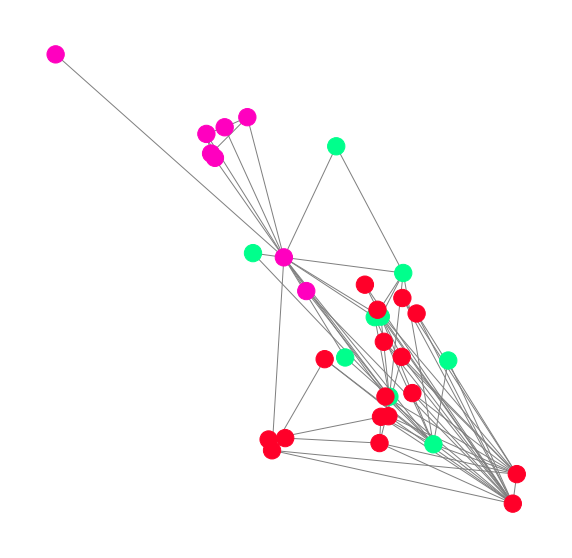

In [90]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
_ = draw_kkl(graph, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

# Training

In [92]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradientDescentOptimizer(learning_rate=2e-2, weight_decay=2.5e-2)

In [93]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50
# lr_rate_ramp = 0 #-0.05
# lr_ramp_steps = 1000

for epoch in range(15000):
    
    y_pred = gcn_model.forward(A_hat, X)

    opt2(y_pred, labels, train_nodes)
    
#     if ((epoch+1) % lr_ramp_steps) == 0:
#         opt2.lr *= 1+lr_rate_ramp
#         print(f"LR set to {opt2.lr:.4f}")

    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update=True)
        
    embeds.append(gcn_model.embedding(A_hat, X))
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print("Early stopping!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.088, Test Loss: 1.075
Epoch: 101, Train Loss: 1.050, Test Loss: 1.044
Epoch: 201, Train Loss: 1.002, Test Loss: 0.994
Epoch: 301, Train Loss: 0.937, Test Loss: 0.923
Epoch: 401, Train Loss: 0.852, Test Loss: 0.826
Epoch: 501, Train Loss: 0.750, Test Loss: 0.714
Epoch: 601, Train Loss: 0.640, Test Loss: 0.608
Epoch: 701, Train Loss: 0.536, Test Loss: 0.526
Epoch: 801, Train Loss: 0.447, Test Loss: 0.471
Epoch: 901, Train Loss: 0.373, Test Loss: 0.434
Epoch: 1001, Train Loss: 0.312, Test Loss: 0.409
Epoch: 1101, Train Loss: 0.262, Test Loss: 0.392
Epoch: 1201, Train Loss: 0.222, Test Loss: 0.380
Epoch: 1301, Train Loss: 0.191, Test Loss: 0.372
Epoch: 1401, Train Loss: 0.166, Test Loss: 0.366
Epoch: 1501, Train Loss: 0.146, Test Loss: 0.362
Epoch: 1601, Train Loss: 0.131, Test Loss: 0.360
Epoch: 1701, Train Loss: 0.119, Test Loss: 0.358
Epoch: 1801, Train Loss: 0.110, Test Loss: 0.357
Epoch: 1901, Train Loss: 0.102, Test Loss: 0.356
Epoch: 2001, Train Loss: 0.095, 

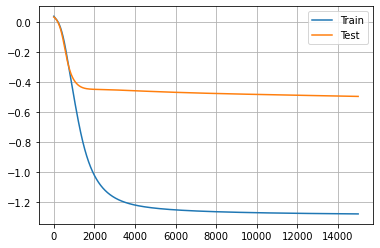

In [94]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [95]:
accs[-1]

0.8709677419354839

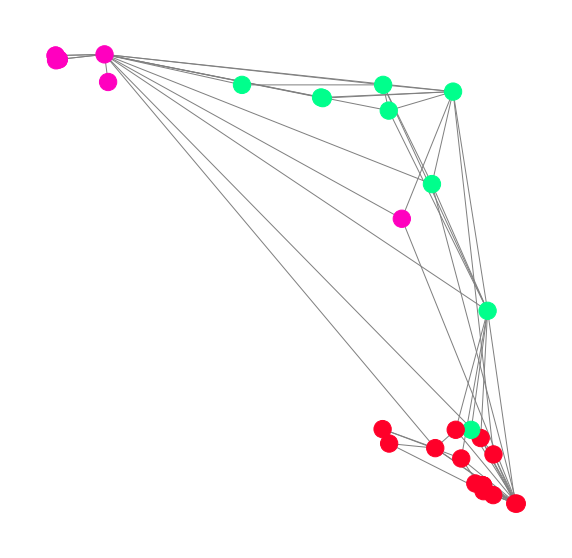

In [96]:
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

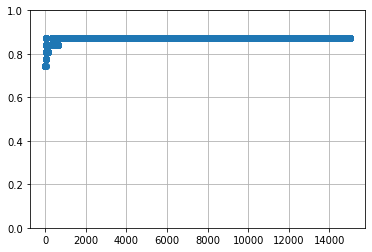

In [97]:
fig, ax = plt.subplots()
_ = ax.plot(accs, marker='o')
ax.grid()
_ = ax.set(ylim=[0,1])